# National Tsing Hua University Robust and Stochastic Portfolio Optimization (Fall 2021)

 - Week 1 Programming HW


In [2]:
# basic
import numpy as np 
import pandas as pd
import datetime as dt 

# yahoo data source
from pandas_datareader import  data as pdr 

# optimization package
import cvxpy as cp 
from scipy.optimize import minimize

# matplotlib
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

# Prioblem 1.1 (iii) 

the following three constraintsets

$$ { x:∥x∥_{1} ≤1 } $$ 
$$ { x:∥x∥_{2} ≤1 } $$ 
$$ { x:∥x∥_{∞} ≤1 } $$ 

in R2 on the same figure  Are they nested?

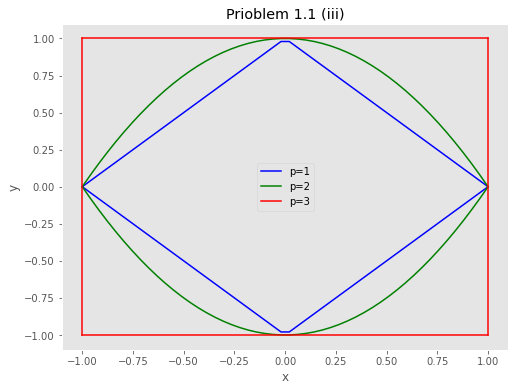

In [2]:
x = np.linspace(-1,1)

lp1_1 = [ 1-np.abs(element) for element in x ]
lp1_2 = [np.abs(element)-1  for element in x ]

lp2_1 = [ 1- np.square(element) for element in x ]
lp2_2 = [ np.square(element)-1  for element in x ]

lp3_1 = [ np.max([element,1])  for element in x ]
lp3_2 = [ np.min([element,-1]) for element in x ]


fig,ax = plt.subplots(figsize=(8,6))
ax.set_title('Prioblem 1.1 (iii)')

# p = 1 
ax.plot(x,lp1_1,color='b',label='p=1')
ax.plot(x,lp1_2,color='b')

# p = 2 
ax.plot(x,lp2_1,color='green',label='p=2')
ax.plot(x,lp2_2,color='green')

# p = 3
ax.plot(x,lp3_1,color='red',label='p=3')
ax.plot(x,lp3_2,color='red')
ax.plot(lp3_1,x,color='red')
ax.plot(lp3_2,x,color='red')

# ------
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.grid()

Problem 1.6

Given a coveriance matrix 

$$ \Sigma =  \left[ \begin{array} {cccc}
0.0144  & 0.0144 & 0.0012 \\
0.0144  & 0.04   & 0.005 \\
0.0012  & 0.005  & 0.0025 \\
\end{array} \right] $$

Use Python to Solve the following (Markowitz’s) quadratic optimization problem

$$ min f(x) =  w^T Σ w  $$

$$ s.t. w^T 1 = 1 $$

$$ ,w≥0 $$


# Using CVXPY package 

In [29]:
class CVX_Markowitz_Optimization():
    
    def __init__(self,cov):

        self.cov    = cov 
        self.params = cp.Variable(cov.shape[1],)

    def Objective_Function(self,params,cov):

        portfolio_risk = cp.quad_form(params,cov) 

        return  cp.Minimize( (1/2) * portfolio_risk  )  
    
    def constraint_1(self):
        
        return cp.sum(self.params) == 1
    
    def constraint_2(self):

        bound = [ self.params[i] >= float(1e-20) for i in range(self.cov.shape[1]) ] 

        return bound 

    def Optimize(self):

        constraints = []
        constraints.extend( [self.constraint_1()] )
        constraints.extend(  self.constraint_2()  )

        prob  = cp.Problem(self.Objective_Function(self.params,self.cov), constraints )
        return prob , self.params


In [14]:
Cov_Matrix = np.array([[0.0144,0.0144,0.0012],[0.0144, 0.04,0.005],[0.0012,0.005,0.0025]])
Cov_Matrix

array([[0.0144, 0.0144, 0.0012],
       [0.0144, 0.04  , 0.005 ],
       [0.0012, 0.005 , 0.0025]])

In [15]:
Model  = CVX_Markowitz_Optimization(cov=Cov_Matrix)
Result,Params = Model.Optimize()
print("Min F(x) : "       , Result.solve() )
print("Weights Values : " , Params.value   )

Min F(x) :  0.0011951957503448277
Weights Values :  [0.08891724 0.001      0.91008276]


# (ii) (More Assets Involved) find 10 different risky assets (stocks, ETFs, etc.) 

that you are interested in and download their corresponding daily adjusted closing prices for a one-year period from 2019 to 2020. 

You may find the historical price data in https://finance.yahoo.com/. Then use these data to calculate the corresponding covariance matrix. 

Then resolve the quadratic programming problem using CVX, report your optimal solution, and optimal value.

In [16]:
class Company_Data():
    """
    ticker     --> list (str)
    start ,end --> datetime 
    peirods    --> string
    """
    def __init__(self,tickers,start,end,periods):

        self.start   = start 
        self.end     = end 
        self.tickers = tickers
        self.periods = periods
    
    def get_data(self,ticker):

        self.df = pdr.get_data_yahoo(ticker,self.start,self.end).reset_index()
   
        return self.df 
    
    def Address_Date(self,date):
        
        date = str(date)
        return date[:10]
        
    def get_price_data(self):

        for i , ticker in enumerate(self.tickers) : 
            
            if i == 0 :
                Price_DF = self.get_data(ticker)
                Price_DF = Price_DF[['Date','Adj Close']]
                Price_DF.columns = ['Date',str(ticker)]
            else:
                Merge_DF = self.get_data(ticker)[['Date','Adj Close']]
                Merge_DF.columns = ['Date',str(ticker)]
                Price_DF = Price_DF.merge(Merge_DF,how='outer')
        
        Price_DF = Price_DF.fillna(value=0)
        Price_DF['Date'] = Price_DF.apply(lambda x : self.Address_Date(x['Date']),axis=1)
        Price_DF.index = Price_DF['Date']
        Price_DF = Price_DF.drop(['Date'],axis=1)
        return Price_DF


# ------------ Company_DF parameters ------------ 
start   = dt.datetime(2019,1,1)
end     = dt.datetime(2020,1,1)
tickers = ["FB","MSFT","AAPL","AMZN","NFLX",'GOOG','TSLA','AMD','^DJI','^VIX']

# ------------ ------------ ------------ ------------ 
Company_Price = Company_Data(tickers=tickers,start=start,end=end,periods="Daily")
Stock_DF      = Company_Price.get_price_data()
Stock_DF

,FB,MSFT,AAPL,AMZN,NFLX,GOOG,TSLA,AMD,^DJI,^VIX
Date,,,,,,,,,,
2018-12-31,131.089996,98.397255,38.338482,1501.969971,267.660004,1035.609985,66.559998,18.459999,23327.460938,25.420000
2019-01-02,135.679993,97.961327,38.382233,1539.130005,267.660004,1045.849976,62.023998,18.830000,23346.240234,23.219999
2019-01-03,131.740005,94.357513,34.559071,1500.280029,271.200012,1016.059998,60.071999,17.049999,22686.220703,25.450001
2019-01-04,137.949997,98.746010,36.034382,1575.390015,297.570007,1070.709961,63.537998,19.000000,23433.160156,21.379999
2019-01-07,138.050003,98.871948,35.954170,1629.510010,315.339996,1068.390015,66.991997,20.570000,23531.349609,21.400000
...,...,...,...,...,...,...,...,...,...,...
2019-12-24,205.119995,154.718262,70.129517,1789.209961,333.200012,1343.560059,85.050003,46.540001,28515.449219,12.670000
2019-12-26,207.789993,155.986465,71.520912,1868.770020,332.630005,1360.400024,86.188004,46.630001,28621.390625,12.650000
2019-12-27,208.100006,156.271561,71.493759,1869.800049,329.089996,1351.890015,86.075996,46.180000,28645.259766,13.430000


In [20]:
Returns_DF = Stock_DF.pct_change().dropna()
Returns_DF.cov()

,FB,MSFT,AAPL,AMZN,NFLX,GOOG,TSLA,AMD,^DJI,^VIX
FB,0.000308,0.000115,0.000136,0.000157,0.000159,0.000151,0.000119,0.000231,0.000064,-0.000605
MSFT,0.000115,0.000156,0.000128,0.000129,0.000133,0.000119,0.000111,0.000225,0.000075,-0.000642
AAPL,0.000136,0.000128,0.000271,0.000140,0.000138,0.000140,0.000169,0.000277,0.000093,-0.000712
AMZN,0.000157,0.000129,0.000140,0.000208,0.000168,0.000134,0.000123,0.000269,0.000072,-0.000637
NFLX,0.000159,0.000133,0.000138,0.000168,0.000476,0.000149,0.000198,0.000290,0.000078,-0.000702
GOOG,0.000151,0.000119,0.000140,0.000134,0.000149,0.000231,0.000112,0.000216,0.000070,-0.000606
TSLA,0.000119,0.000111,0.000169,0.000123,0.000198,0.000112,0.000965,0.000286,0.000076,-0.000649
AMD,0.000231,0.000225,0.000277,0.000269,0.000290,0.000216,0.000286,0.001150,0.000149,-0.001264
^DJI,0.000064,0.000075,0.000093,0.000072,0.000078,0.000070,0.000076,0.000149,0.000061,-0.000485
^VIX,-0.000605,-0.000642,-0.000712,-0.000637,-0.000702,-0.000606,-0.000649,-0.001264,-0.000485,0.006013


In [31]:
Model  = CVX_Markowitz_Optimization(cov=Returns_DF.cov() * 252 )
Result,Params = Model.Optimize()

print("Min F(x) : "       , Result.solve()                      )
print("Weights Values : " , np.round(Params.value,decimals=2)   )  

Min F(x) :  0.0023678086572227206
Weights Values :  [0.03 0.   0.   0.   0.   0.   0.   0.   0.89 0.08]


# Using scipy.optimization package

In [3]:
class Scipy_Markowitz_Optimization():

    def __init__(self,Coveriance_Matrix):

        self.initial_weight = np.zeros((Coveriance_Matrix.shape[0], 1))               # setting expected portfolio return and the tolerate portfolio variance
        self.bounds         = [(0,None) for i in range(Coveriance_Matrix.shape[0])]   # can't short stock
        self.cov            = Coveriance_Matrix
    
    def objective_function(self,w) :  # portfolio Shrape Ratio --> maximize

        w_tp           = w.transpose()
        portfolio_risk = w_tp @ self.cov @ w
        
        return (1/2) * portfolio_risk 

    def equality_constraint(self,w) : # weight sum = 1

        return 1 - np.sum(w)
    
    def optimization(self):

        constraint_1 = {'type': 'eq','fun':  self.equality_constraint} # weight sum = 1
        constraint   = [constraint_1]
        
        result = minimize(self.objective_function,self.initial_weight, method='SLSQP', bounds=self.bounds , constraints=constraint)
            
        return result

In [4]:
Cov_Matrix = np.array([[0.0144,0.0144,0.0012],[0.0144, 0.04,0.005],[0.0012,0.005,0.0025]])
Cov_Matrix

array([[0.0144, 0.0144, 0.0012],
       [0.0144, 0.04  , 0.005 ],
       [0.0012, 0.005 , 0.0025]])

In [11]:
Objective_Function = Scipy_Markowitz_Optimization(Cov_Matrix)
Objective_Function.optimization()

     fun: 0.0011917241379310348
     jac: array([0.00238345, 0.00584276, 0.00238345])
 message: 'Optimization terminated successfully'
    nfev: 40
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([8.96551652e-02, 4.16333634e-17, 9.10344835e-01])

In [12]:
Objective_Function = Scipy_Markowitz_Optimization(Returns_DF.cov()*252)
Objective_Function.optimization()

     fun: 0.0023697148432832017
     jac: array([0.0047123 , 0.00508389, 0.00791182, 0.00489797, 0.00499992,
       0.00513262, 0.0052184 , 0.01038019, 0.00478683, 0.00416958])
 message: 'Optimization terminated successfully'
    nfev: 220
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([2.38439863e-02, 0.00000000e+00, 7.80625564e-18, 0.00000000e+00,
       0.00000000e+00, 6.91784620e-03, 1.30104261e-18, 5.20417043e-18,
       8.91457553e-01, 7.77806150e-02])